<a href="https://colab.research.google.com/github/mlelarge/dataflowr/blob/master/CEA_EDF_INRIA/CAM_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class Activation Map


http://cnnlocalization.csail.mit.edu/


https://github.com/metalbubble/CAM

In [0]:
import io
import requests
from PIL import Image
import torch
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb
from matplotlib.pyplot import imshow

# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'

In [2]:
net = models.resnet18(pretrained=True)
finalconv_name = 'layer4'

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 63537218.37it/s]


In [5]:
!pip install torchviz #git+https://github.com/szagoruyko/pytorchviz
from torchviz import make_dot

     |████████████████████████████████| 51kB 3.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


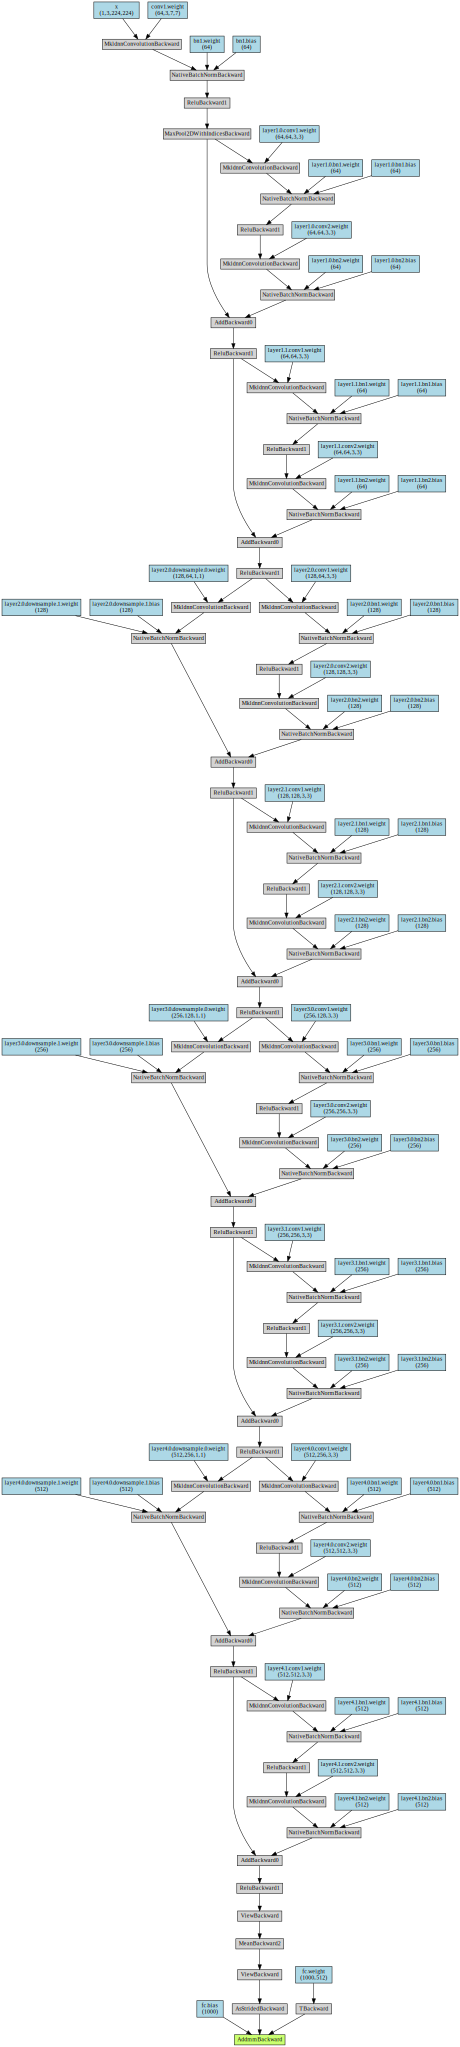

In [6]:
x = torch.randn(1, 3, 224, 224).requires_grad_(True)
y = net(x)
make_dot(y, params=dict(list(net.named_parameters()) + [('x', x)]))

In [0]:
net.eval()

# hook the feature extractor
# see https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html
# for more explanations
features_blobs = []
def hook_feature(module, input, output):
    print('Inside ' + module.__class__.__name__ + ' forward')
    print('')
    print('input: ', type(input))
    print('input[0]: ', type(input[0]))
    print('output: ', type(output))
    print('')
    print('input size:', input[0].size())
    print('output size:', output.data.size())
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature);

In [8]:
net._modules.get(finalconv_name)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, mome

In [0]:
# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

the last parameter is the bias

In [10]:
params[-1].size()

torch.Size([1000])

and the before last parameter is the last matrix from the fc layer

In [11]:
weight_softmax.shape

(1000, 512)

<src='CMAP.png'>

In Resnet architecture, we do average pooling before the last fc layer.

<img src ='CMAP.png'>

source Zhou et al.

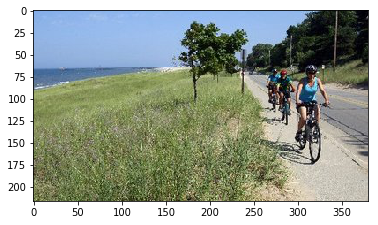

In [12]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil.save('test.jpg')
imshow(img_pil);

In [13]:
img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable)

Inside Sequential forward

input:  <class 'tuple'>
input[0]:  <class 'torch.Tensor'>
output:  <class 'torch.Tensor'>

input size: torch.Size([1, 256, 14, 14])
output size: torch.Size([1, 512, 7, 7])


Resnet architectures:
<img src='resnet.png'>

In [0]:
# download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

In [15]:
# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.252 -> lakeside, lakeshore
0.152 -> alp
0.131 -> mountain bike, all-terrain bike, off-roader
0.092 -> seashore, coast, seacoast, sea-coast
0.054 -> worm fence, snake fence, snake-rail fence, Virginia fence


In [16]:
# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)

output CAM.jpg for the top1 prediction: lakeside, lakeshore


True

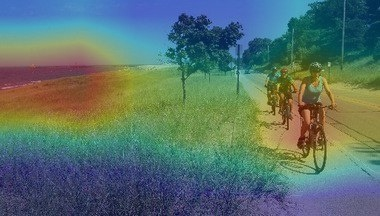

In [17]:
from IPython.display import Image
Image("CAM.jpg")

In [18]:
# generate class activation mapping for the top1 prediction
CAM1s = returnCAM(features_blobs[0], weight_softmax, [idx[2]])

# render the CAM and output
print('output CAM1.jpg for the top3 prediction: %s'%classes[idx[2]])
img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAM1s[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM1.jpg', result)

output CAM1.jpg for the top3 prediction: mountain bike, all-terrain bike, off-roader


True

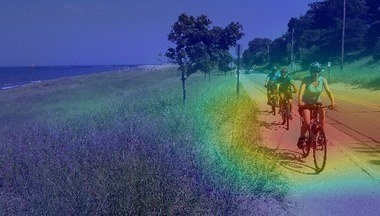

In [19]:
Image("CAM1.jpg")